In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import linalg as LA
from scipy.signal import cont2discrete



import QPMatrices as QP
from apply_mpc_to_sys import apply_mpc_to_sys
from cost_function_parameter import cost_function_parameter
from system_model import system_model
from utils import cont_mat
from utils import obv_mat


from constants import Ts, I, Nc, x0, d, Dis_time, prediction_horizon, rm

In [2]:

Ac, Bc, Cc, Dc = system_model()
print("A = {}, \n B = {}, \n C =  {}".format(Ac, Bc, Cc))

A = [[-0.01587302  0.          0.02564103  0.        ]
 [ 0.         -0.01098901  0.          0.01785714]
 [ 0.          0.         -0.02564103  0.        ]
 [ 0.          0.          0.         -0.01785714]], 
 B = [[0.04822143 0.        ]
 [0.         0.03495625]
 [0.         0.07755   ]
 [0.05593125 0.        ]], 
 C =  [[0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]]


In [3]:
# Discretized system using Scipy package using ZOH method

disc_sys = cont2discrete((Ac, Bc, Cc, Dc), Ts, method='zoh')



# We unpack the tuple here
(A, B, C, D) = disc_sys[0:4]

print("A = {}, \n B = {}, \n C =  {} \n D = {}".format(A, B, C, D))



A = [[0.96875258 0.         0.04919749 0.        ]
 [0.         0.97826174 0.         0.03469906]
 [0.         0.         0.95001068 0.        ]
 [0.         0.         0.         0.96491594]], 
 B = [[0.09492809 0.00386858]
 [0.00195955 0.06914983]
 [0.         0.1511902 ]
 [0.10988852 0.        ]], 
 C =  [[0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]] 
 D = [[0. 0.]
 [0. 0.]]


In [4]:

# check whether the system is controllable and observable


print("Controllability rank is {}".format(np.linalg.matrix_rank(cont_mat(A,B))))

print("Observability rank is {}".format(np.linalg.matrix_rank(obv_mat(A,C))))

Controllability rank is 4
Observability rank is 4


In [5]:
# Here we want to form the matrices for the LQ in compact form


# The cost function parameters
n = np.size(A, 0)
m = np.size(B, 1)
p = np.size(C, 0)



P, Q, R, umax, umin, ymax, ymin = cost_function_parameter(n, m, p)





In [6]:
# Here we compute the Compact matrices given in the paper; note we need to 
   # compute them only once

state_data = {}
input_data = {}

F_tilde_data = {}
Z_tilde_data = {}







# properties for the random transformation
time_varying_trans = False



for N in prediction_horizon:

    H, F, Y, G, W, O, calS, calR, calQ, S, calT = QP.QP_matrices(N, A, B, C,
                                                                P, Q, R, umin, umax, ymin, ymax)
    print("singular values for F matrix to check if it is full column rank: {}".format(LA.svdvals(F)))
    
    state_data['X_N_{}'.format(N)], input_data['U_N_{}'.format(N)],F_tilde_data['F_N_{}'.format(N)], Z_tilde_data['Z_N_{}'.format(N)] = apply_mpc_to_sys(time_varying_trans,
                                                                                                                                                          rm, H, F, G, W, O, x0, A, B,
                                                                                                                                                            m, p, I, N, Nc, Dis_time, d)

# Save data
# name = my_data
np.savez("my_data", F_tilde_data=F_tilde_data, Z_tilde_data=Z_tilde_data,
          A=A, B=B, state_data=state_data, input_data=input_data,
            prediction_horizon=prediction_horizon)



singular values for F matrix to check if it is full column rank: [3.2440757  2.63072146 0.05714884 0.04426338]
singular values for F matrix to check if it is full column rank: [23.51976321 11.49139576  1.40240625  0.91367786]


singular values for F matrix to check if it is full column rank: [63.61296428 19.59950624  3.94487211  3.15157639]


['X_N_5', 'X_N_20', 'X_N_50']


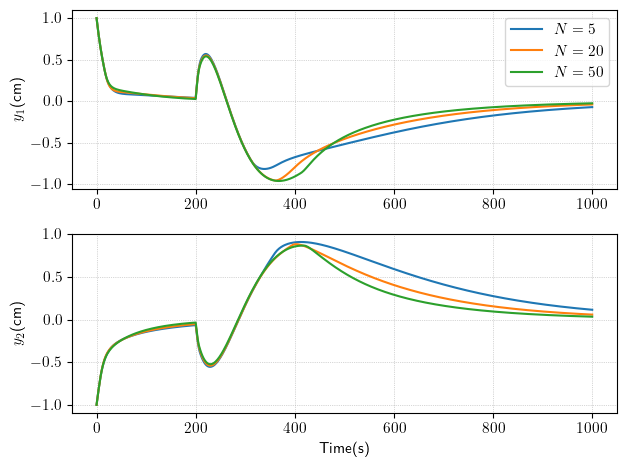

In [7]:

# Here we plot the system response that we have received from the previous block

Time_steps = np.arange((Nc*I) + 1) * Ts


plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 11})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


fig = plt.figure()
ax = fig.subplots(2,1)

a = list(state_data.keys())
print(a)
# plot here
ax[0].plot(Time_steps, 0.5 * state_data[a[0]][0,:], Time_steps, 0.5 * state_data[a[1]][0,:],
            Time_steps, 0.5 * state_data[a[2]][0,:])
ax[1].plot(Time_steps, 0.5 * state_data[a[0]][1,:], Time_steps, 0.5 * state_data[a[1]][1,:],
            Time_steps, 0.5 * state_data[a[2]][1,:])






# add information here
ax[0].grid(linestyle='dotted', linewidth=0.5)
ax[1].grid(linestyle='dotted', linewidth=0.5)
ax[0].set_ylabel(r"$y_1$(cm)")
ax[1].set_ylabel(r"$y_2$(cm)")
ax[1].set_xlabel("Time(s)")
ax[0].legend(('$N={}$'.format(prediction_horizon[0]),"$N={}$".format(prediction_horizon[1]),
              '$N={}$'.format(prediction_horizon[2])))




plt.tight_layout()




fig.savefig("outputs.pdf", transparent=True, dpi=300)

plt.show()

In [8]:

from sklearn.metrics import mean_squared_error as mse

K = np.size(state_data[a[0]][0:2,:], 1)
y_true = np.zeros((p, K))

e5 = mse(y_true, state_data[a[0]][0:2,:], squared=False)
e20 = mse(y_true, state_data[a[1]][0:2,:], squared=False)
e50 = mse(y_true, state_data[a[2]][0:2,:], squared=False)

print('e5 {}, e20 {} and e50 {}'.format(e5, e20, e50))



e5 0.7513269875732027, e20 0.6407484570744287 and e50 0.5820184686801942


['U_N_5', 'U_N_20', 'U_N_50']


/tmp/ipykernel_19528/663188128.py:42: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


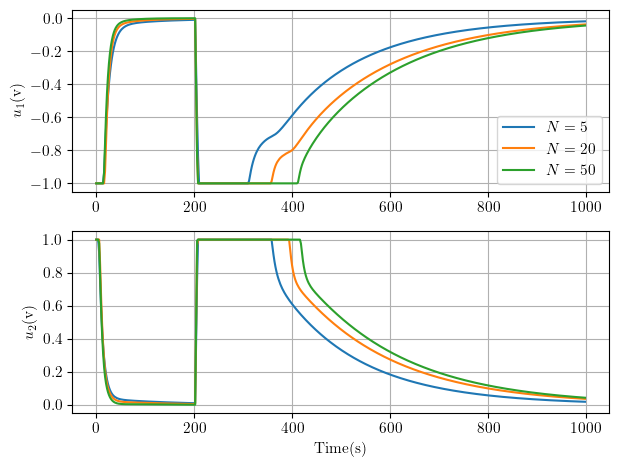

In [9]:
Time_steps = np.arange((Nc*I) ) * Ts
b = list(input_data.keys())
print(b)


fig = plt.figure()
ax = fig.subplots(2,1)

# plot here
ax[0].plot(Time_steps, input_data[b[0]][0,:], Time_steps, input_data[b[1]][0,:],
            Time_steps, input_data[b[2]][0,:])
ax[1].plot(Time_steps, input_data[b[0]][1,:], Time_steps, input_data[b[1]][1,:],
            Time_steps, input_data[b[2]][1,:])



mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')


# add information here
ax[0].grid()
ax[1].grid()
ax[0].set_ylabel(r"$u_1$(v)")
ax[1].set_ylabel(r"$u_2$(v)")
ax[1].set_xlabel("Time(s)")
ax[0].legend(('$N={}$'.format(prediction_horizon[0]),"$N={}$".format(prediction_horizon[1]),
              '$N={}$'.format(prediction_horizon[2])))

# fig.suptitle(r"\TeX\ is Number "
#           r"$\displaystyle\sum_{n=1}^\infty\frac{-e^{i\pi}}{2^n}$!",
#           fontsize=16, color='gray')



plt.tight_layout()


# save the figure here
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.style.use('seaborn-paper')

fig.savefig("inputs.eps", transparent=True)

plt.show()